## **Table of Contents**
> 1. [Notebook Imports](#1)
> 2. [Importing Data](#2)
> 3. [Feature Engineering](#3)
> 4. [Text Preprocessing](#4)
> 5. [Data Visualization](#5)
> 6. [Text Vectorization](#6)
> 7. [Naive Bayes](#7)
> 8. [Random Forest](#8)

<div style='color: #216969;
           background-color: #EAF6F6;
           font-size: 200%;
           border-radius:15px;
           text-align:center;
           font-weight:600;
           border-style: solid;
           border-color: dark green;
           font-family: "Verdana";'>
Notebook Imports
<a class="anchor" id="1"></a> 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import re
import string
from wordcloud import WordCloud
from collections import Counter

import warnings
warnings.filterwarnings('ignore')

from nltk import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from scikitplot.metrics import plot_confusion_matrix, plot_roc

<div style='color: #216969;
           background-color: #EAF6F6;
           font-size: 200%;
           border-radius:15px;
           text-align:center;
           font-weight:600;
           border-style: solid;
           border-color: dark green;
           font-family: "Verdana";'>
Importing Data
<a class="anchor" id="2"></a> 

In [3]:
data = pd.read_csv('../input/spam-text-message-classification/SPAM text message 20170820 - Data.csv')
data.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [4]:
print(data.shape)

(5572, 2)


In [5]:
data.isnull().sum()

Category    0
Message     0
dtype: int64

In [6]:
data['mailcontent'] = data['Message']

Let us start by checking the number of spam and ham messages we have in our dataset

In [15]:
data = data.drop(columns = ['Message'],axis =1)

In [16]:
data['Category'].value_counts()

ham     4825
spam     747
Name: Category, dtype: int64

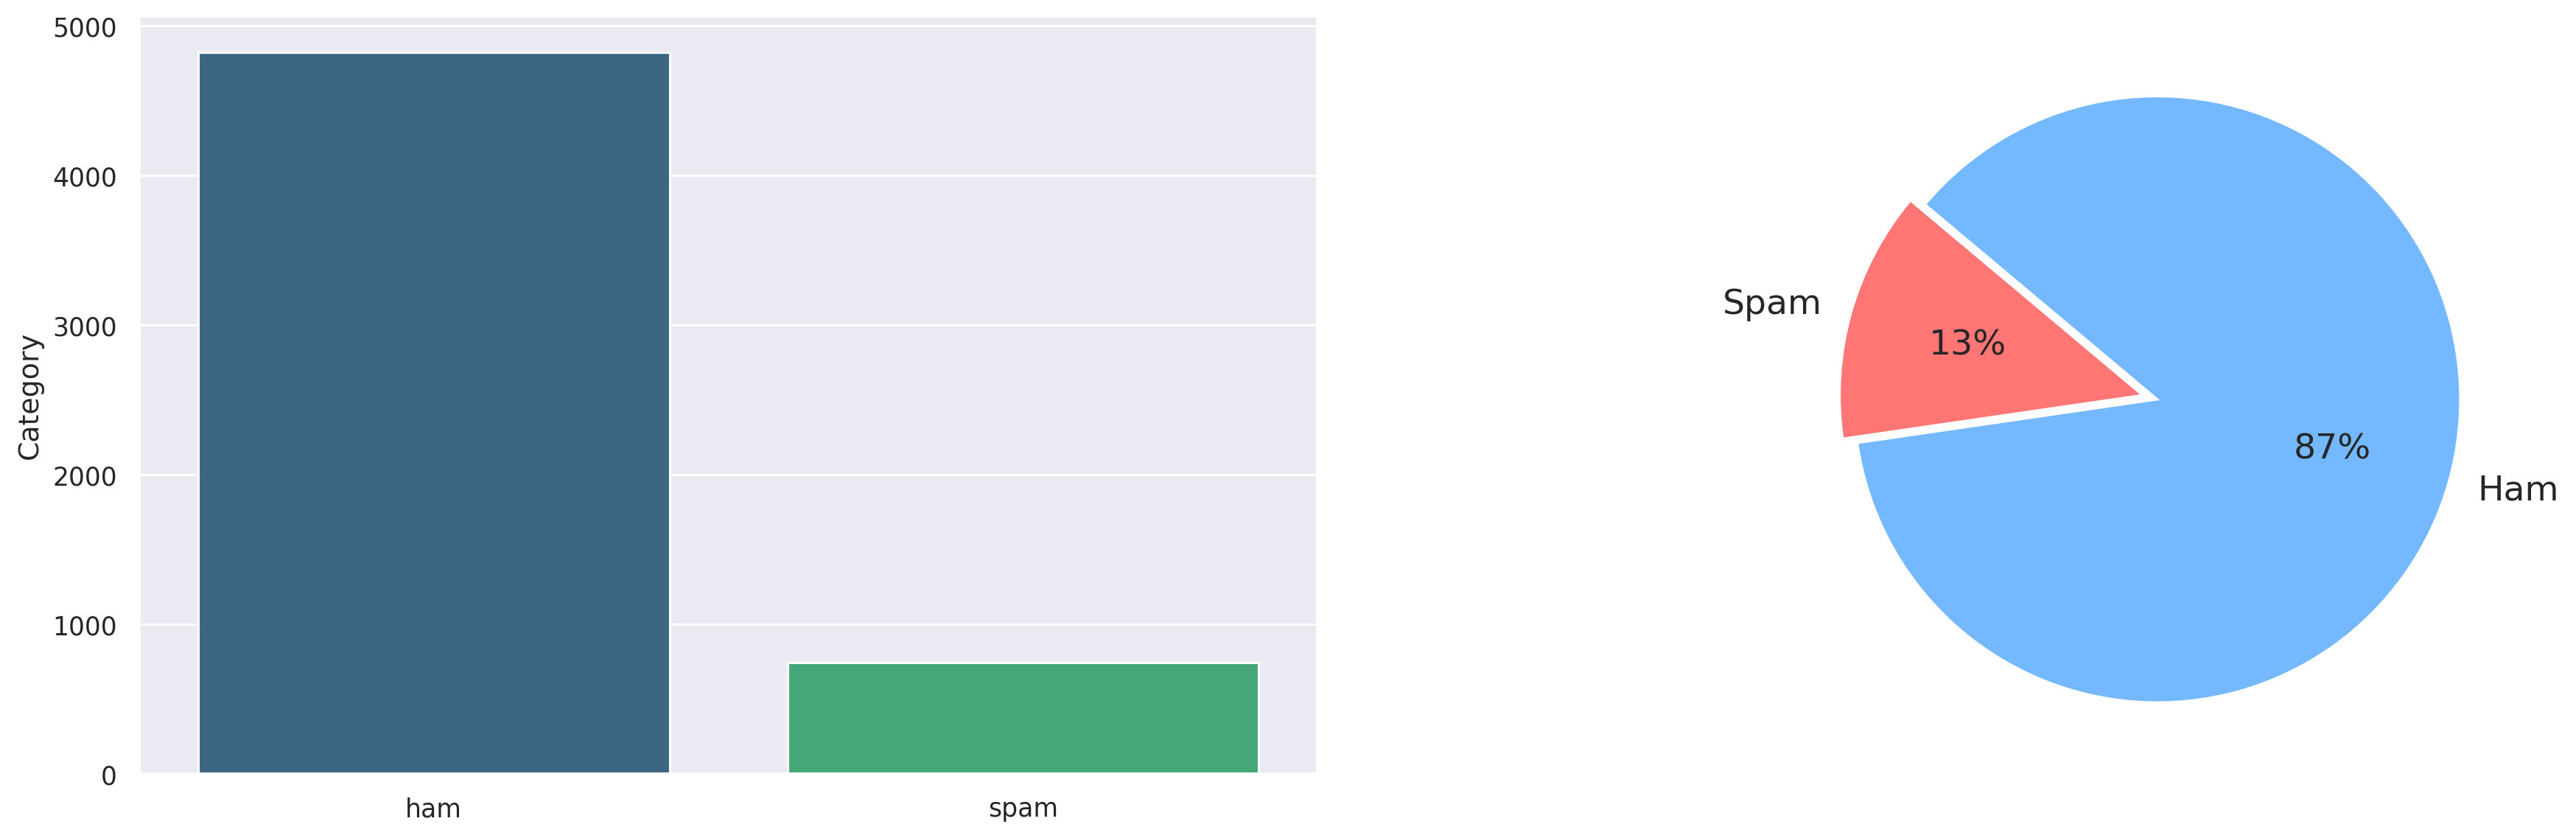

In [17]:
labels = ['Spam', 'Ham']
sizes = [747, 4825]
custom_colours = ['#ff7675', '#74b9ff']

plt.figure(figsize=(20, 6), dpi=227)
plt.subplot(1, 2, 2)
plt.pie(sizes, labels = labels, textprops={'fontsize': 15}, startangle=140, 
       autopct='%1.0f%%', colors=custom_colours, explode=[0, 0.05])

plt.subplot(1, 2, 1)
sns.barplot(x = data['Category'].unique(), y = data['Category'].value_counts(), palette= 'viridis')

plt.show()

<div style='color: #216969;
           background-color: #EAF6F6;
           font-size: 200%;
           border-radius:15px;
           text-align:center;
           font-weight:600;
           border-style: solid;
           border-color: dark green;
           font-family: "Verdana";'>
Feature Engineering
<a class="anchor" id="3"></a> 

In [18]:
data['Total Words'] = data['mailcontent'].apply(lambda x: len(x.split()))

def count_total_words(text):
    char = 0
    for word in text.split():
        char += len(word)
    return char

data['Total Chars'] = data["mailcontent"].apply(count_total_words)
print(data['Total Chars'])

0        92
1        24
2       128
3        39
4        49
       ... 
5567    131
5568     29
5569     48
5570    100
5571     21
Name: Total Chars, Length: 5572, dtype: int64


In [19]:
data.head()

,Category,mailcontent,Total Words,Total Chars
0,ham,"Go until jurong point, crazy.. Available only ...",20,92
1,ham,Ok lar... Joking wif u oni...,6,24
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,28,128
3,ham,U dun say so early hor... U c already then say...,11,39
4,ham,"Nah I don't think he goes to usf, he lives aro...",13,49


We have created 2 new features in our dataset, lets try to see how our target variable changes based on these features

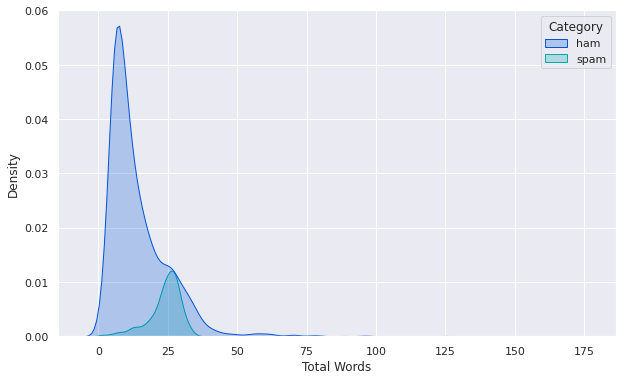

In [20]:
plt.figure(figsize = (10, 6))
sns.kdeplot(x = data['Total Words'], hue= data['Category'], palette= 'winter', shade = True)
plt.show()

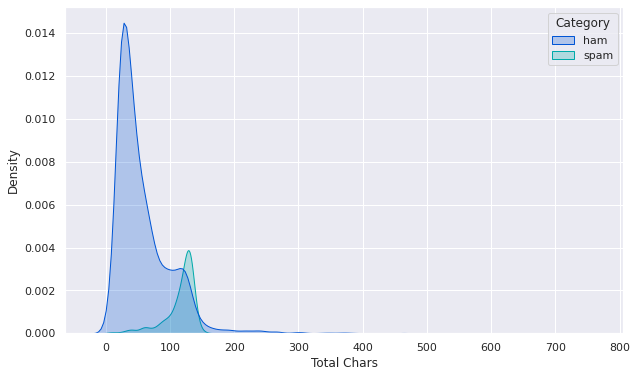

In [21]:
plt.figure(figsize = (10, 6))
sns.kdeplot(x = data['Total Chars'], hue= data['Category'], palette= 'winter', shade = True)
plt.show()

Clearly, one thing we can conclude here is that more the number of words in a text, there are more chances of it being spam

<div style='color: #216969;
           background-color: #EAF6F6;
           font-size: 200%;
           border-radius:15px;
           text-align:center;
           font-weight:600;
           border-style: solid;
           border-color: dark green;
           font-family: "Verdana";'>
Text Preprocessing
<a class="anchor" id="4"></a> 

In [63]:
data.head()

,Category,mailcontent,Total Words,Total Chars,Total Words After Transformation
0,1,go jurong point crazi avail bugi n great wor...,20,92,2.995732
1,1,ok lar joke wif u oni,6,24,2.079442
2,0,free entri 2 wkli comp win fa cup final tkt 21...,28,128,3.401197
3,1,u dun say earli hor u c alreadi say,11,39,2.397895
4,1,nah nt think goe usf live around though,13,49,2.197225


#### **Lowercasing**

In [64]:
def convert_lowercase(text):
    text = text.lower()
    return text

data['mailcontent'] = data['mailcontent'].apply(convert_lowercase)

#### **Removing URLs**

In [65]:
def remove_url(text):
    re_url = re.compile('https?://\S+|www\.\S+')
    return re_url.sub('', text)

data['mailcontent'] = data['mailcontent'].apply(remove_url)

#### **Removing Punctuations**

In [66]:
exclude = string.punctuation

def remove_punct(text):
    return text.translate(str.maketrans('', '', exclude))

data['mailcontent'] = data['mailcontent'].apply(remove_punc)

#### **Removing stopwords**

In [67]:
def remove_punc(text):
    new_list = []
    words = word_tokenize(text)
    stopwrds = stopwords.words('english')
    for word in words:
        if word not in stopwrds:
            new_list.append(word)
    return ' '.join(new_list)

data['mailcontent'] = data['mailcontent'].apply(remove_stopwords)

#### **Stemming**

In [68]:
def perform_stemming(text):
    stemmer = PorterStemmer()
    new_list = []
    words = word_tokenize(text)
    for word in words:
        new_list.append(stemmer.stem(word))

    return " ".join(new_list)

data['mailcontent'] = data['mailcontent'].apply(perform_stemming)

In [69]:
data['Total Words After Transformation'] = data['mailcontent'].apply(lambda x: np.log(len(x.split())))

In [70]:
data.head()

,Category,mailcontent,Total Words,Total Chars,Total Words After Transformation
0,1,go jurong point crazi avail bugi n great world...,20,92,2.772589
1,1,ok lar joke wif u oni,6,24,1.791759
2,0,free entri 2 wkli comp win fa cup final tkt 21...,28,128,3.218876
3,1,u dun say earli hor u c alreadi say,11,39,2.197225
4,1,nah nt think goe usf live around though,13,49,2.079442


<div style='color: #216969;
           background-color: #EAF6F6;
           font-size: 200%;
           border-radius:15px;
           text-align:center;
           font-weight:600;
           border-style: solid;
           border-color: dark green;
           font-family: "Verdana";'>
Text Vectorization
<a class="anchor" id="6"></a> 

In [71]:
X = data["mailcontent"]
y = data['Category'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state= 42, stratify = y)

In [72]:
tfidf = TfidfVectorizer(max_features= 2500, min_df= 2)
X_train = tfidf.fit_transform(X_train).toarray()
X_test = tfidf.transform(X_test).toarray()

<div style='color: #216969;
           background-color: #EAF6F6;
           font-size: 200%;
           border-radius:15px;
           text-align:center;
           font-weight:600;
           border-style: solid;
           border-color: dark green;
           font-family: "Verdana";'>
Naive Bayes
<a class="anchor" id="7"></a> 

In [73]:
def train_model(model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)
    accuracy = round(accuracy_score(y_test, y_pred), 3)
    precision = round(precision_score(y_test, y_pred), 3)
    recall = round(recall_score(y_test, y_pred), 3)

    print(f'Accuracy of the model: {accuracy}')
    print(f'Precision Score of the model: {precision}')
    print(f'Recall Score of the model: {recall}')

    sns.set_context('notebook', font_scale= 1.3)
    fig, ax = plt.subplots(1, 2, figsize = (25,  8))
    ax1 = plot_confusion_matrix(y_test, y_pred, ax= ax[0], cmap= 'YlGnBu')
    ax2 = plot_roc(y_test, y_prob, ax= ax[1], plot_macro= False, plot_micro= False, cmap= 'summer')

In [56]:
print(X_test[])

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


Accuracy of the model: 0.967
Precision Score of the model: 0.967
Recall Score of the model: 0.996


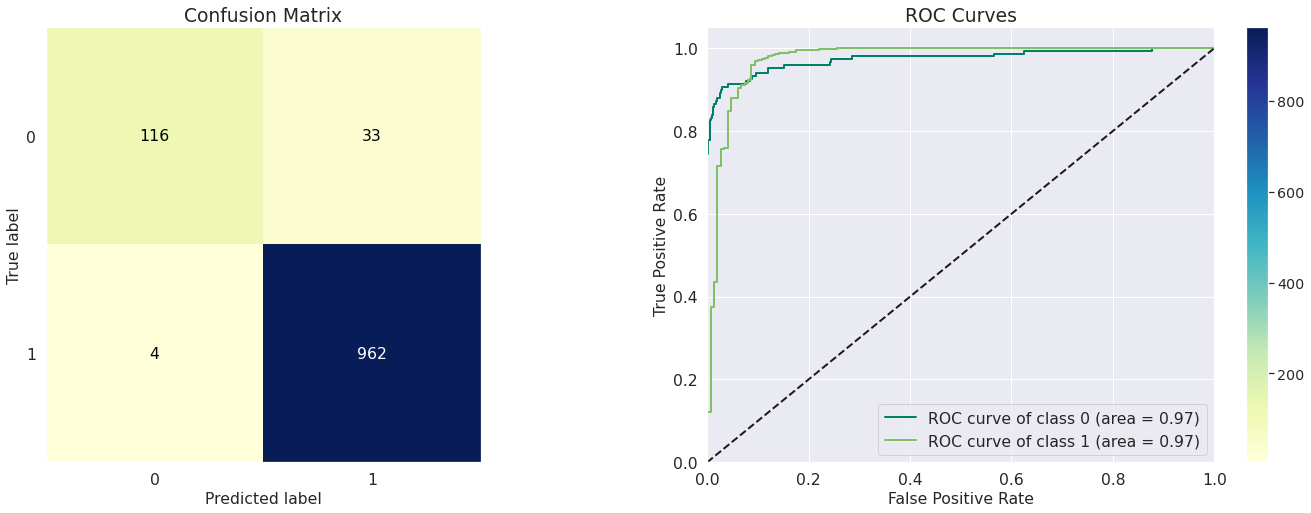

In [49]:
nb = MultinomialNB()
train_model(nb)

<div style='color: #216969;
           background-color: #EAF6F6;
           font-size: 200%;
           border-radius:15px;
           text-align:center;
           font-weight:600;
           border-style: solid;
           border-color: dark green;
           font-family: "Verdana";'>
Random Forest
<a class="anchor" id="8"></a> 

Accuracy of the model: 0.977
Precision Score of the model: 0.975
Recall Score of the model: 0.999


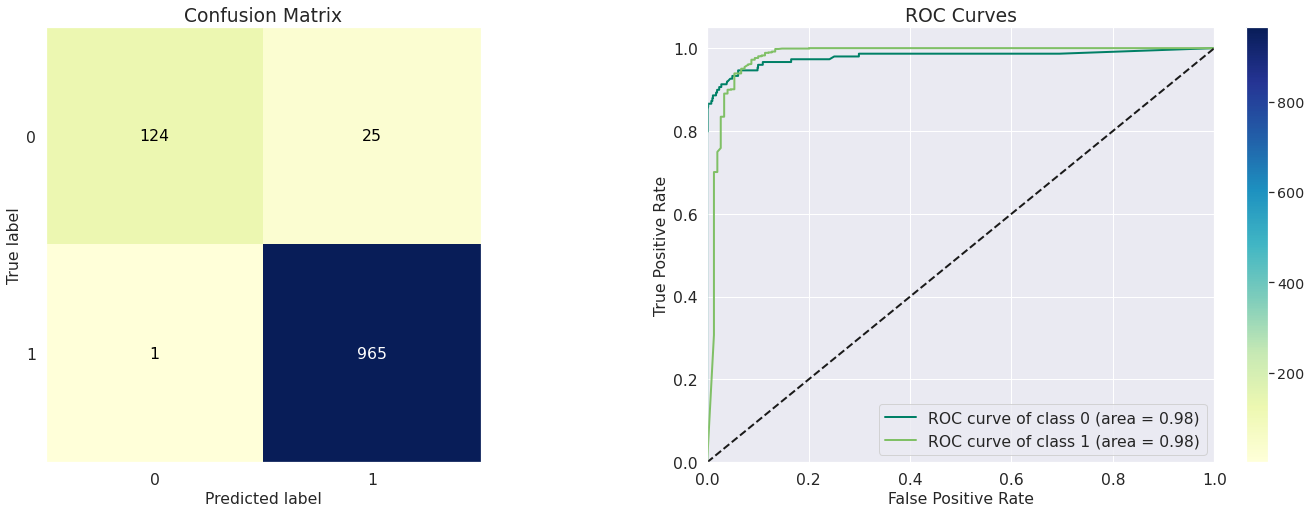

In [50]:
rf = RandomForestClassifier(n_estimators= 300)
train_model(rf)

#### Random Forest has an accuracy of almost 0.98 and a recall score of 1. It also performed better than the naive bayes classifier.

In [ ]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

nltk.download('stopwords')

# Initialize stop words and stemmer
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

def preprocess(text):
    """Preprocess the text data."""
    text = text.lower()
    text = re.sub(r'\b\w{1,2}\b', '', text)  # Remove short words
    text = re.sub(r'\W', ' ', text)  # Remove punctuation
    text = re.sub(r'\s+', ' ', text)  # Remove extra spaces
    tokens = text.split()
    tokens = [stemmer.stem(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)


In [76]:
import joblib
from preprocessing import preprocess

# Load the trained model and vectorizer
model = joblib.load('spam_classifier_model.pkl')
vectorizer = joblib.load('tfidf_vectorizer.pkl')

def classify_email(email_text, model, vectorizer):
    """Classify a new email as spam or ham."""
    processed_email = preprocess(email_text)
    email_features = vectorizer.transform([processed_email]).toarray()
    email_pred = model.predict(email_features)
    email_prob = model.predict_proba(email_features)[:, 1]

    classification = 'spam' if email_pred == 1 else 'ham'
    return classification, email_prob[0]

# List of sample emails
sample_emails = [
    "Congratulations! You've won a $1000 gift card. Click here to claim now.",
    "Hi, could we reschedule our meeting to next week?",
    "Your account has been suspended. Please verify your identity to restore access.",
    "Don't miss out on our special discount offer, valid only for today!",
    "Hey, just checking in to see how you're doing.",
    "You have an unread message from your bank. Please log in to view it.",
    "Reminder: Your subscription is expiring soon. Renew now to continue services.",
    "Let's catch up this weekend. Are you free for a coffee?",
    "Urgent: Action required. Update your billing information to avoid service interruption.",
    "Your friend has tagged you in a photo. Click here to view it."
]

# Classify each sample email
for email in sample_emails:
    classification, probability = classify_email(email, model, vectorizer)
    print(f'Email: "{email}"\nClassification: {classification}\nProbability of being spam: {probability:.3f}\n')


ImportError: cannot import name 'preprocess' from 'preprocessing' (/opt/conda/lib/python3.7/site-packages/preprocessing/__init__.py)

In [75]:
!pip install joblib

In [77]:
from sklearn.externals import joblib

# Assuming you have already trained your model and vectorizer
joblib.dump(model, 'spam_classifier_model.pkl')
joblib.dump(vectorizer, 'tfidf_vectorizer.pkl')


ImportError: cannot import name 'joblib' from 'sklearn.externals' (/opt/conda/lib/python3.7/site-packages/sklearn/externals/__init__.py)